# Predictor Manager Examples

This notebook demonstrates the use of `PredictorManager` to manage all predictor implementations with pooling and async support.


## Setup


In [1]:
import sys
sys.path.append('../..')

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from core.inference.manager import PredictorManager, PredictorConfig
from core.inference.predictors.impl.grounding_dino_object_detector import GroundingDinoObjectDetector
from core.inference.predictors.impl.sam2_object_segmenter import Sam2ObjectSegmenter
from core.inference.predictors.impl.two_stage_object_segmenter import TwoStageObjectSegmenter
from core.inference.predictors.impl.lama_image_inpainter import LamaImageInpainter

from core.inference.predictors.label_based_object_detector import LabelBasedObjectDetector
from core.inference.predictors.box_based_object_segmenter import BoxBasedObjectSegmenter
from core.inference.predictors.label_based_object_segmenter import LabelBasedObjectSegmenter
from core.inference.predictors.mask_based_image_inpainter import MaskBasedImageInpainter

from utils.image import expand_mask_image


c:\Users\nghia\miniconda3\envs\mic2e\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\nghia\miniconda3\envs\mic2e\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


## Initialize Manager and Register Predictors


In [2]:
# Paths
GROUNDING_DINO_CONFIG = "../../config/GroundingDINO_SwinT_OGC.py"
GROUNDING_DINO_WEIGHTS = "../weights/groundingdino_swint_ogc.pth"
SAM2_CONFIG = "../../config/sam2.1_hiera_1.yaml"
SAM2_WEIGHTS = "../weights/sam2.1_hiera_large.pt"
LAMA_WEIGHTS = "../weights/big-lama.pt"
IMAGE_PATH = "../images/pexels-photo-1108099.webp"

# Create manager
manager = PredictorManager()

# Register GroundingDINO detector (pool_size=1, preload=True)
manager.register(PredictorConfig(
    predictor_class=GroundingDinoObjectDetector,
    init_args={
        "checkpoint_path": GROUNDING_DINO_WEIGHTS,
        "config_path": GROUNDING_DINO_CONFIG,
        "box_threshold": 0.35,
        "text_threshold": 0.25
    },
    pool_size=1,
    device="cuda",
    preload=True
))

# Register SAM2 segmenter (pool_size=1, preload=True)
manager.register(PredictorConfig(
    predictor_class=Sam2ObjectSegmenter,
    init_args={
        "checkpoint_path": SAM2_WEIGHTS,
        "config_path": SAM2_CONFIG
    },
    pool_size=1,
    device="cuda",
    preload=True
))

# Register LaMa inpainter (pool_size=1, preload=False - loads on demand)
manager.register(PredictorConfig(
    predictor_class=LamaImageInpainter,
    init_args={
        "model_path": LAMA_WEIGHTS
    },
    pool_size=1,
    device="cuda",
    preload=False
))

print("✓ Manager initialized with 3 predictors")


✓ Manager initialized with 3 predictors


## Load Image


Image size: (500, 375)


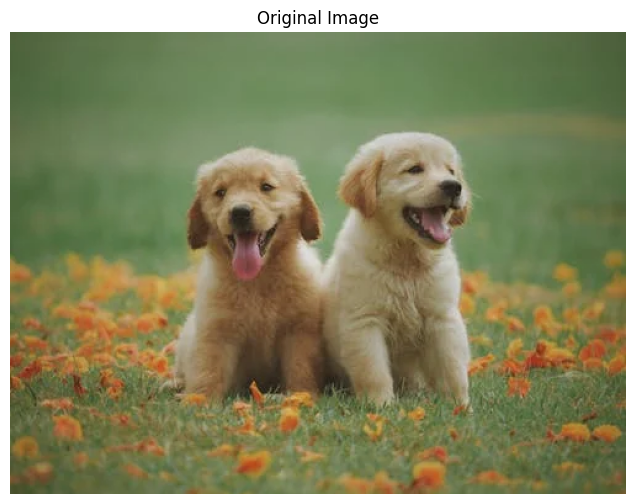

In [3]:
image = Image.open(IMAGE_PATH)
print(f"Image size: {image.size}")

plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.show()


## Example 1: Object Detection

Request a `LabelBasedObjectDetector` - the manager will provide the GroundingDINO detector.


In [4]:
async with manager.get_predictor(LabelBasedObjectDetector) as detector:
    detected = detector.detect_with_label(image, "person")
    print(f"Found {len(detected)} person(s)")
    
    for i, obj in enumerate(detected):
        print(f"  {i+1}. {obj.label} - Score: {obj.score:.3f}, BBox: {obj.bbox}")


c:\Users\nghia\miniconda3\envs\mic2e\lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


c:\Users\nghia\miniconda3\envs\mic2e\lib\site-packages\transformers\modeling_utils.py:1625: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\nghia\miniconda3\envs\mic2e\lib\site-packages\torch\_dynamo\eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
c:\Users\nghia\miniconda3\envs\mic2e\lib\site-packages\torch\utils\checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Found 2 person(s)
  1. person - Score: 0.491, BBox: (252, 79, 376, 307)
  2. person - Score: 0.466, BBox: (125, 92, 257, 305)


c:\Users\nghia\miniconda3\envs\mic2e\lib\site-packages\groundingdino\models\GroundingDINO\transformer.py:862: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


## Example 2: Box-Based Segmentation

Request a `BoxBasedObjectSegmenter` - the manager will provide the SAM2 segmenter.


Segmented 3 object(s)


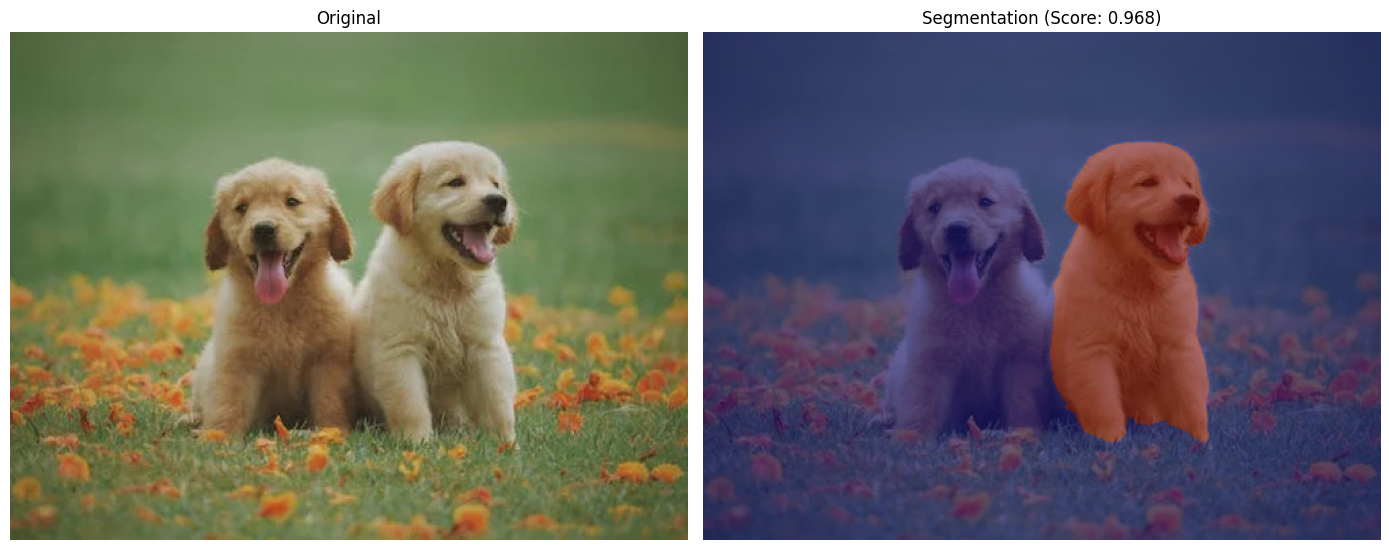

In [5]:
if detected:
    bbox = detected[0].bbox
    
    async with manager.get_predictor(BoxBasedObjectSegmenter) as segmenter:
        segmented = segmenter.segment_with_box(image, bbox)
        print(f"Segmented {len(segmented)} object(s)")
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    axes[0].imshow(image)
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    mask = np.array(segmented[0].mask)
    axes[1].imshow(image)
    axes[1].imshow(mask, alpha=0.5, cmap='jet')
    axes[1].set_title(f"Segmentation (Score: {segmented[0].score:.3f})")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()


## Example 3: Inpainting

Request a `MaskBasedImageInpainter` - the manager will provide the LaMa inpainter.


✓ Inpainting complete


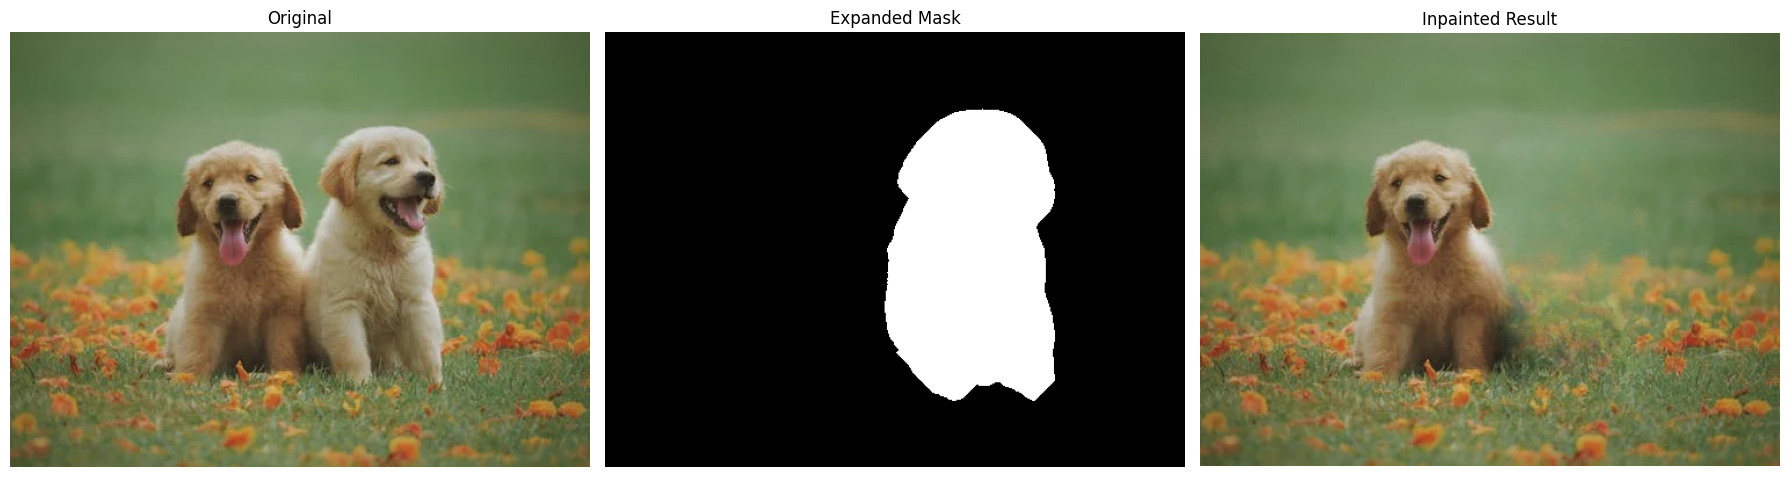

In [6]:
if segmented:
    mask = segmented[0].mask
    expanded_mask = expand_mask_image(mask, iterations=15)
    
    async with manager.get_predictor(MaskBasedImageInpainter) as inpainter:
        inpainted = inpainter.inpaint_with_mask(image, expanded_mask)
        print("✓ Inpainting complete")
    
    # Visualize
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(image)
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    axes[1].imshow(expanded_mask, cmap='gray')
    axes[1].set_title("Expanded Mask")
    axes[1].axis('off')
    
    axes[2].imshow(inpainted)
    axes[2].set_title("Inpainted Result")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()


## Example 4: Multiple Operations in Sequence

Use different predictors in a single workflow - the manager handles everything automatically.


In [7]:
async def detect_segment_inpaint(image, label):
    """Complete pipeline: detect → segment → inpaint."""
    
    # Step 1: Detect
    async with manager.get_predictor(LabelBasedObjectDetector) as detector:
        detected = detector.detect_with_label(image, label)
    
    if not detected:
        print(f"No '{label}' detected")
        return None
    
    print(f"✓ Detected {len(detected)} {label}(s)")
    
    # Step 2: Segment
    async with manager.get_predictor(BoxBasedObjectSegmenter) as segmenter:
        segmented = segmenter.segment_with_box(image, detected[0].bbox)
    
    print(f"✓ Segmented object")
    
    # Step 3: Inpaint
    mask = expand_mask_image(segmented[0].mask, iterations=12)
    async with manager.get_predictor(MaskBasedImageInpainter) as inpainter:
        result = inpainter.inpaint_with_mask(image, mask)
    
    print(f"✓ Inpainted object")
    
    return result

# Run the pipeline
result = await detect_segment_inpaint(image, "chair")

if result:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].imshow(image)
    axes[0].set_title("Original")
    axes[0].axis('off')
    
    axes[1].imshow(result)
    axes[1].set_title("Chair Removed")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()


No 'chair' detected


## Example 5: Concurrent Operations

Run multiple predictions concurrently using asyncio.


In [8]:
import asyncio

async def detect_multiple_labels(image, labels):
    """Detect multiple labels concurrently."""
    
    async def detect_one(label):
        async with manager.get_predictor(LabelBasedObjectDetector) as detector:
            results = detector.detect_with_label(image, label)
            return label, results
    
    # Run all detections concurrently
    tasks = [detect_one(label) for label in labels]
    results = await asyncio.gather(*tasks)
    
    return dict(results)

# Detect multiple objects at once
labels = ["person", "chair", "dog"]
all_detections = await detect_multiple_labels(image, labels)

for label, detections in all_detections.items():
    print(f"{label}: {len(detections)} detected")


person: 2 detected
chair: 0 detected
dog: 2 detected


## Cleanup


In [9]:
await manager.shutdown()
print("✓ Manager shutdown complete")


✓ Manager shutdown complete


## Summary

The `PredictorManager` provides:

- **Simple API**: Request predictors by base class type
- **Automatic Pooling**: Manages multiple instances efficiently  
- **Async Support**: Full asyncio integration for concurrent operations
- **Resource Management**: Automatic load/unload handling
- **Flexibility**: Register any predictor implementation

### Key Benefits:

1. **Decoupled Code**: Request by interface, not implementation
2. **Efficient Resource Use**: Pooling prevents repeated load/unload
3. **Concurrent Processing**: Run multiple predictions in parallel
4. **Clean Lifecycle**: Simple setup → use → cleanup pattern
